In [1]:
cd ..

C:\Users\CareAware\Consulting_Projects\aesthetic-ai\DeepFL\DeepFL


In [2]:
from ResNet import *
from final_utils import *

In [3]:
root_path = generate_root_path()

## Giving path of folder

In [4]:
if True:
    good_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'benchmark', 'images', 'good', '*'))
    bad_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'benchmark','images', 'bad', '*'))
else:
    good_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'alm', 'splitted', 'alm_bench', 'images', 'good', '*'))
    bad_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'alm', 'splitted', 'alm_bench', 'images', 'bad', '*'))

good_imgs_path = sorted(good_imgs_path)
bad_imgs_path = sorted(bad_imgs_path)

paths = good_imgs_path + bad_imgs_path
labels = np.concatenate((np.ones(len(good_imgs_path)) ,np.zeros(len(bad_imgs_path))))

In [8]:
len(paths)

111

### Some necessary functions

In [9]:
# indxs_mg = np.load('Distillation_Learning/best_res/best_solution_custom_mg.npy')
# indxs_cnn = np.load('Distillation_Learning/best_res/best_solution_custom_cnn.npy')
# # indxs = np.load('Distillation_Learning/best_res/best_solution_custom.npy')
# indxs =  np.concatenate((indxs_mg,indxs_cnn))
indxs = np.load('models/Softmax/best_solution_custom_95.72.npy')
def take_from_vector(data, indxs=indxs):
    new_data = np.squeeze(data[indxs])
    return new_data


In [10]:
indxs

array([ 2620, 14263, 11622, ..., 12844,  3338, 14810], dtype=int64)

In [11]:

def predict(x, y=None, model_gap=None, model=None, model_cnn=None, is_norm=False, 
            pca_mg=None, pca_cnn=None, pca_connected=None, take=False):
    '''
    Does prediction on given numpy image using
    model_gap and model
    '''
    try:
        feat_mg = model_gap.predict(x, verbose=0)
    except:
        x = x[None] #changed 02.08 for evaluator visualizing predictions
        feat_mg = model_gap.predict(x, verbose=0)
        
    if pca_mg:
        feat_mg = pca_mg.transform(feat_mg)        
    if model_cnn:
        feat_cnn = model_cnn.predict(y, verbose=0)
        if is_norm:
            feat_cnn = normalize_feat_vector(feat_cnn)
        if pca_cnn:
            feat_cnn = pca_cnn.transform(feat_cnn)
            
        feat = np.concatenate((np.squeeze(feat_mg), np.squeeze(feat_cnn)))
#         feat = take_from_vector(feat, indxs) # later comment
        
        if pca_connected:
            feat = pca_connected.transform(feat[None])
        if take:
            feat = take_from_vector(feat, indxs)
        feat = feat[None]
    else:
        feat = feat_mg
#     feat = np.squeeze(feat, axis=0)
#     print(feat.shape)
    pred_score = model.predict(feat, verbose=0)

    return pred_score
    

def predict_from_path(model_gap, model, paths, resize_func=None, size=None, for_all=False, save_results=None, 
                      save_to=None, model_cnn=None, is_norm=False, pca_mg = None, pca_cnn = None, pca_connected=None, take=False):
    #always requires list of paths
    predicted = []
    
    for i, path in enumerate(paths):
        img_mg = read_img(path=path, resize_func=resize_func, size=size, for_all=for_all)
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn, pca_connected, take)
        predicted.append(pred_score)
    
    predicted = np.array(predicted)
    predicted = np.squeeze(predicted)
    
    if save_results:
        np.save(save_to, np.argmax(predicted, axis=-1))
        
    return predicted

### Extracting features of benchmark data with Shufflenet and Multigap

#### Multigap

In [9]:
model_gap = model_inceptionresnet_multigap()

In [ ]:
# benchmark good
source_file = root_path + 'Data/AesthAI/benchmark/images/good' 
target_file = root_path + 'Data/AesthAI/benchmark/features/multigap/original/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='',
                                     model=model_gap, 
                                     resize_func=resize_max,
                                     size=(3000,3000),
                                     crop_func=None,
                                     save_json=False)

Source =  D:Data/AesthAI/benchmark/images/good
Target =  D:Data/AesthAI/benchmark/features/multigap/original/


In [13]:
# benchmark bad
source_file = root_path + 'Data/AesthAI/benchmark/images/bad' 
target_file = root_path + 'Data/AesthAI/benchmark/features/multigap/original/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='bad',
                                     splitted='',
                                     model=model_gap, 
                                     resize_func=resize_max,
                                     size=(3000,3000),
                                     crop_func=None,
                                     save_json=False)

Source =  /home/server3090ti/Data/AesthAI/benchmark/images/bad
Target =  /home/server3090ti/Data/AesthAI/benchmark/features/multigap/original/
Extracted all...


#### EfficientNet B7

In [10]:
model_cnn = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",trainable=False) ])

In [15]:
# benchmark good
source_file = root_path + 'Data/AesthAI/benchmark/images/good' 
target_file = root_path + 'Data/AesthAI/benchmark/features/cnn_efficientnet_b7/border_600x600/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='',
                                     model=model_cnn, 
                                     resize_func=resize_add_border,
                                     size=(600,600),
                                     crop_func=None,
                                     save_json=False)

Source =  /home/server3090ti/Data/AesthAI/benchmark/images/good
Target =  /home/server3090ti/Data/AesthAI/benchmark/features/cnn_efficientnet_b7/border_600x600/
Extracted all...


In [16]:
# benchmark bad
source_file = root_path + 'Data/AesthAI/benchmark/images/bad' 
target_file = root_path + 'Data/AesthAI/benchmark/features/cnn_efficientnet_b7/border_600x600/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='bad',
                                     splitted='',
                                     model=model_cnn, 
                                     resize_func=resize_add_border,
                                     size=(600,600),
                                     crop_func=None,
                                     save_json=False)

Source =  /home/server3090ti/Data/AesthAI/benchmark/images/bad
Target =  /home/server3090ti/Data/AesthAI/benchmark/features/cnn_efficientnet_b7/border_600x600/
Extracted all...


#### Resnet

In [12]:
# model_resnet = ResNet18(num_classes=3409)
# model_resnet.build((None, 600, 600, 3))
# weights_path = 'models/ResNet/ResNet_original_border_600x600.hdf5'
# model_resnet.load_weights(weights_path)
model_path = 'models/ResNet/ResNet_5k_996_95_72'
model_resnet = keras.models.load_model(model_path)

In [13]:
glob(root_path + f'Data/AesthAI/benchmark/features/resnet/*')

['D:Data/AesthAI/benchmark/features/resnet\\border_600x600',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_3409',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_3k',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_3k_test',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_5k_93_01',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_5k_94_24',
 'D:Data/AesthAI/benchmark/features/resnet\\border_600x600_5k_augm']

In [14]:
# os.mkdir(root_path + f'Data/AesthAI/benchmark/features/resnet/all_res_996_5k_95_72')

In [12]:
# benchmark good
source_file = root_path + 'Data/AesthAI/benchmark/images/good' 
target_file = root_path + 'Data/AesthAI/benchmark/features/resnet/border_996x996_5k_95_72/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='',
                                     model=model_resnet, 
                                     resize_func=resize_add_border,
                                     size=(996,996),
                                     crop_func=None,
                                     save_json=False)

Source =  D:Data/AesthAI/benchmark/images/good
Target =  D:Data/AesthAI/benchmark/features/resnet/border_996x996_5k_95_72/
Extracted all...


In [13]:
# benchmark bad
source_file = root_path + 'Data/AesthAI/benchmark/images/bad' 
target_file = root_path + 'Data/AesthAI/benchmark/features/resnet/border_996x996_5k_95_72/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='bad',
                                     splitted='',
                                     model=model_resnet, 
                                     resize_func=resize_add_border,
                                     size=(996,996),
                                     crop_func=None,
                                     save_json=False)

Source =  D:Data/AesthAI/benchmark/images/bad
Target =  D:Data/AesthAI/benchmark/features/resnet/border_996x996_5k_95_72/
Extracted all...


### Loading features of benchmark data  extracted with Resnet and Multigap from .json

In [13]:
benchmark_feats_path = root_path + 'Data/AesthAI/benchmark/'
feats_MG = 'all_res_996'
feats_resnet = 'border_996x996_5k_95_72'
feats_cnn = 'border_600x600'
benchmark_multigap_feats = []
benchmark_resnet_feats = []

benchmark_good_json = open(f'{benchmark_feats_path}/data_good.json')
benchmark_bad_json = open(f'{benchmark_feats_path}/data_bad.json')
benchmark_good_feats = json.load(benchmark_good_json)
benchmark_bad_feats = json.load(benchmark_bad_json)

for data in benchmark_good_feats:
    multigap_feats_path = benchmark_feats_path + f'features/multigap/{feats_MG}/' + data['feature']
    cnn_feats_path = benchmark_feats_path + f'features/cnn_efficientnet_b7/{feats_cnn}/' + data['feature']
    resnet_feats_path = benchmark_feats_path + f'features/resnet/{feats_resnet}/' + data['feature']
    
    connected = np.concatenate((np.squeeze(np.load(multigap_feats_path)), np.squeeze(np.load(cnn_feats_path))))
#     print(connected.shape)
    connected = take_from_vector(connected, indxs)
#     print(connected.shape)
#     print(np.load(resnet_feats_path).shape)

#     print(take_from_vector(np.load(multigap_feats_path)).shape)
    benchmark_multigap_feats.append(connected[None])
    resnet = np.squeeze(np.load(resnet_feats_path))
#     resnet_concat = np.concatenate((resnet, connected[3409:]))
    benchmark_resnet_feats.append(resnet)

for data in benchmark_bad_feats:
    multigap_feats_path = benchmark_feats_path + f'features/multigap/{feats_MG}/' + data['feature']
    cnn_feats_path = benchmark_feats_path + f'features/cnn_efficientnet_b7/{feats_cnn}/' + data['feature']
    resnet_feats_path = benchmark_feats_path + f'features/resnet/{feats_resnet}/' + data['feature']
    
    connected = np.concatenate((np.squeeze(np.load(multigap_feats_path)), np.squeeze(np.load(cnn_feats_path))))
    
    connected = take_from_vector(connected, indxs)
#     print(np.load(resnet_feats_path).shape)
    
    benchmark_multigap_feats.append(connected[None])
    resnet = np.squeeze(np.load(resnet_feats_path))
#     resnet_concat = np.concatenate((resnet, connected[3409:]))
    benchmark_resnet_feats.append(resnet)
    
    
benchmark_resnet_feats = np.squeeze(benchmark_resnet_feats)
benchmark_multigap_feats = np.squeeze(benchmark_multigap_feats)

In [14]:
benchmark_multigap_feats.shape

(111, 5000)

In [15]:
benchmark_resnet_feats.shape

(111, 5000)

## Creating model

In [16]:
model = fc_model_softmax(input_num=5000)
model_resnet = fc_model_softmax(input_num=5000)
# weights_path = 'Distillation_Learning/best_res/best_custom_2.hdf5'
# # 'Genetic_Algorithm/best_res/best_custom_90.09_91.78.hdf5'  #'models/Softmax/model_fc_softmax_26_08_128bs_epoch15.hdf5'
# #  models/Softmax/MG_Take_3k.hdf5
model_path = 'models/Softmax/best_custom_95.72.hdf5'
model_resnet.load_weights(model_path)
weights_path = 'models/Softmax/best_custom_95.72.hdf5'
model.load_weights(weights_path)

In [17]:
pred_mg = model.predict(benchmark_multigap_feats)
pred_resnet = model.predict(benchmark_resnet_feats)

4/4 [==============================] - 0s 9ms/step


In [18]:
multigap_predicted_binary = np.argmax(pred_mg, axis=1) 
resnet_predicted_binary = np.argmax(pred_resnet, axis=1) 

In [19]:
multigap_predicted_binary

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [20]:
resnet_predicted_binary

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1], dtype=int64)

## Prediction

In [36]:
# multigap_predicted = predict_from_path(model_gap, model, paths, resize_func=resize_max, size=(3000, 3000), for_all=False,
#                                        model_cnn=model_cnn, take=True)
# multigap_predicted_binary = np.argmax(multigap_predicted, axis=1)
# multigap_predicted_binary

In [37]:
# resnet_predicted = predict_from_path(model_resnet, model, paths, resize_func=resize_add_border, size=(996, 996), for_all=False)
# resnet_predicted_binary = np.argmax(resnet_predicted, axis=1)
# resnet_predicted_binary

## Binary Accuracy

In [21]:
def calc_acc(labels, predicted):
    return (labels == predicted).sum() / len(labels)

In [22]:
acc = calc_acc(multigap_predicted_binary, resnet_predicted_binary)
print(f'Accuracy resnet with multigap predicted: {acc}')

Accuracy resnet with multigap predicted: 0.7117117117117117


In [23]:
acc = calc_acc(multigap_predicted_binary, labels)
print(f'Accuracy multigap with original binary labels: {acc}')

Accuracy multigap with original binary labels: 0.8828828828828829


In [24]:
acc = calc_acc(labels, resnet_predicted_binary)
print(f'Accuracy resnet with original binary labels: {acc}')

Accuracy resnet with original binary labels: 0.7027027027027027


## L1 on probabilities

In [25]:
def L1_prob(tf_prob, pt_prob):
    return ((np.abs(tf_prob[:, 0] - pt_prob[:, 0]) + np.abs(tf_prob[:, 1] - pt_prob[:, 1])) / 2).mean()

In [26]:
L1_prob(pred_mg, pred_resnet)

0.3134696

## L1 on features

In [27]:
def L1(tf_feats, pt_feats):
    return np.abs(tf_feats - pt_feats).mean()

In [28]:
L1(benchmark_multigap_feats, benchmark_resnet_feats)

1.043696

## Plotting

In [29]:
benchmark_multigap_feats = np.squeeze(benchmark_multigap_feats)

In [30]:
benchmark_shufflenet_feats = np.squeeze(benchmark_resnet_feats)

Scatter of 100 vector with given range (100, 3409)


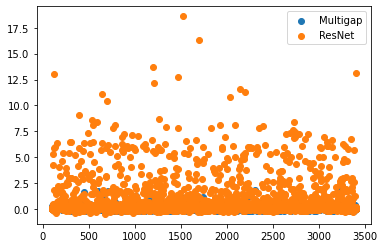

In [31]:
i_element = 100
feats_range = (100, 3409)

print(f'Scatter of {i_element} vector with given range {feats_range}')

plt.scatter(np.arange(feats_range[0], feats_range[1]), benchmark_multigap_feats[i_element][feats_range[0]:feats_range[1]], label='Multigap');
plt.scatter(np.arange(feats_range[0], feats_range[1]), benchmark_shufflenet_feats[i_element][feats_range[0]:feats_range[1]], label='ResNet');
plt.legend()
plt.show();